In [1]:
# import必要的包
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

from xgboost import XGBClassifier
import xgboost as xgb

/Users/randy/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 读数据
train = pd.read_csv('./data/RentListingInquries_FE_train.csv')
test = pd.read_csv('./data/RentListingInquries_FE_test.csv')

In [3]:
y_train = train.interest_level
X_train = train.drop("interest_level", axis=1)

# 第二步2：调整树的参数：max_depth & min_child_weight
(精调，参数的步长为1)

In [5]:
# 定义GridSearchCV要搜索的参数
# 上一步是看到max_depth在5附近就是最好的了，下一步可以在5周围再找找点
# 而min_child_weight还可以往上再走一下
max_depth = [4,5,6]
min_child_weight = [5,6,7]
params_2_2 = {
    "max_depth" : max_depth,
    "min_child_weight" : min_child_weight
}
params_2_2

{'max_depth': [4, 5, 6], 'min_child_weight': [5, 6, 7]}

In [7]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

xgb_2_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=272,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)


g_search_2_2 = GridSearchCV(xgb_2_2, param_grid = params_2_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
g_search_2_2.fit(X_train , y_train)

g_search_2_2.grid_scores_, g_search_2_2.best_params_,     g_search_2_2.best_score_

/Users/randy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.59204, std: 0.00427, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.59153, std: 0.00423, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.59136, std: 0.00405, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: -0.58846, std: 0.00312, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.58960, std: 0.00350, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.58852, std: 0.00363, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -0.58903, std: 0.00374, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.58853, std: 0.00339, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -0.58850, std: 0.00387, params: {'max_depth': 6, 'min_child_weight': 7}],
 {'max_depth': 5, 'min_child_weight': 5},
 -0.58845569521075314)

可以看到还是在[5,5]节点的时候损失最小，于是我们将[5,5]作为定好的参数继续做其他参数的调参

Best: -0.588456 using {'max_depth': 5, 'min_child_weight': 5}


/Users/randy/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/randy/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/randy/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/randy/anaconda3/lib/python3.6

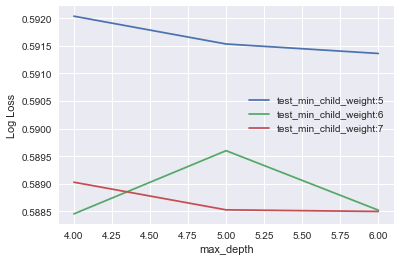

In [11]:
# summarize results
print("Best: %f using %s" % (g_search_2_2.best_score_, g_search_2_2.best_params_))
test_means = g_search_2_2.cv_results_[ 'mean_test_score' ]
test_stds = g_search_2_2.cv_results_[ 'std_test_score' ]
train_means = g_search_2_2.cv_results_[ 'mean_train_score' ]
train_stds = g_search_2_2.cv_results_[ 'std_train_score' ]

pd.DataFrame(g_search_2_2.cv_results_).to_csv('maxdepth_min_child_weights_2.csv')

# plot results
test_scores = np.array(test_means).reshape(len(min_child_weight), len(max_depth))
train_scores = np.array(train_means).reshape(len(min_child_weight), len(max_depth))

for i, value in enumerate(min_child_weight):
    plt.plot(max_depth, -test_scores[i], label= 'test_min_child_weight:'   + str(value))

sns.set()
plt.legend()
plt.xlabel( 'max_depth' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig( 'max_depth_vs_min_child_weght.png' )